In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv('BTC_daily.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3273,2023-09-03,25869.472656,26087.148438,25817.031250,25969.566406,25969.566406,8962524523
3274,2023-09-04,25968.169922,26081.525391,25657.025391,25812.416016,25812.416016,10680635106
3275,2023-09-05,25814.957031,25858.375000,25589.988281,25779.982422,25779.982422,11094740040
3276,2023-09-06,25783.931641,25953.015625,25404.359375,25753.236328,25753.236328,12752705327


In [4]:
data = df['Close'].values
lows = df['Low'].values
highs = df['High'].values
data = data[:-1]
lows = lows[:-1]
highs = highs[:-1]

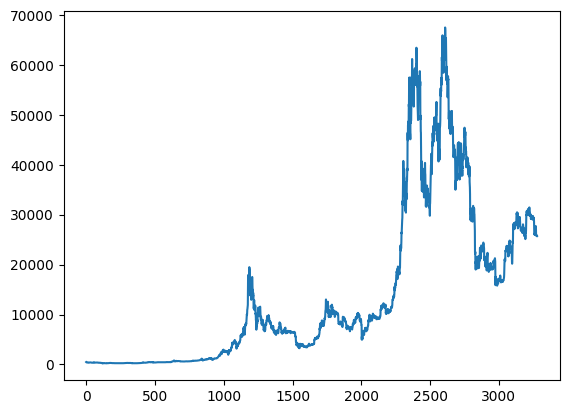

In [5]:
data = df['Close'].values
plt.plot(data)

In [6]:
def check(avgtradetime , avgtradeprofit):
    print("The best model finished training with avrage trade time of " + str(avgtradetime) + " and avrage profit of " + str(avgtradeprofit) + " per year. :)")

In [7]:
def SMA(n , dat):
    sma_list = [0] * (n - 1)
    for i in range(n, dat.shape[0]+1):
        sma_list.append(np.mean(dat[i-n:i]))
    return(sma_list)

In [8]:
def CUTS(sma1 , sma2): # sma1 shorter than sma2
    buy = []
    sell = []
    old = 1
    for i in range(len(sma1)):
        if (sma1[i]>=sma2[i]):
            new = 1
        else:
            new = -1
        if (old != new):
            if (new==-1) :
                sell.append(i)
            else:
                buy.append(i)
        old = new
    return buy , sell

In [239]:
def PROFITS (buys , sells , lows , highs, data , l , pos):
    fees = 0.9999
    profit = []
    if (len(buys)>0):
        if (buys[0] > sells[0]):
            for i in range(len(buys)):
                maxi = np.max(highs[sells[i]:buys[i]+1])
                allowed = data[sells[i]] * (1 + 1/l)*(fees**(4*(buys[i] - sells[i] + np.argmax(highs[sells[i]:buys[i]+1]))))
                if (allowed > maxi):
                    p =  (((data[sells[i]] - data[buys[i]])/data[buys[i]])*l*pos)*(fees**(4*(buys[i] - sells[i])))
                    profit.append(p)
                    #print("short")

                else:
                    p = -1 * pos*(fees**(4*(buys[i] - sells[i] + np.argmax(highs[sells[i]:buys[i]+1]))))
                    profit.append(p)
                if (i!=(len(buys)-1)):
                    mini = np.min(lows[buys[i]:sells[i+1]])
                    allowed = data[buys[i]] * (1 - 1/l)/(fees**(4*(buys[i] - sells[i+1] + np.argmin(lows[buys[i]:sells[i+1]+1]))))
                    if (allowed < mini):
                        p = (((data[sells[i+1]] - data[buys[i]+1])/data[buys[i]])*l*pos)*(fees**(4*(sells[i+1] - buys[i])))
                        profit.append(p)
                        #print("long")
                    else:
                        p = -1 * pos*(fees**(4*(buys[i] - sells[i+1] + np.argmin(lows[buys[i]:sells[i+1]+1]))))
                        profit.append(p)
        else :
            for i in range(len(buys)):
                print("shit, we fuckedup in PROFITS function")
                p = (((data[sells[i]] - data[buys[i]])/data[buys[i]])*l*p)/(fees**(4*sells[i] - buys[i]))
                profit.append(p)
    profit = profit[1:]
    return profit

In [240]:
def RATE(profs):
    fees = 0.999
    if (len(profs)>0):
        numtrades = len(profs)
        maxdrawdown = min(profs) 
        maxwin = max(profs)
        allprofit = 1
        multiplyer = [1] # your money in time
        for i in profs: 
            multiplyer.append(allprofit * (1 + i) * fees)
            allprofit = allprofit * (1 + i)*fees
        return numtrades , maxdrawdown , maxwin , allprofit , multiplyer 
    else:
        return 0 , 0  , 0 , 1 , [1]

In [241]:
N = 1095
l = 1
p = 0.35
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])
        
numtradess = np.zeros((200 , 200) , dtype = float )
maxdrawdowns = np.zeros((200 , 200) , dtype = float )
maxwins = np.zeros((N , 200 , 200) , dtype = float )
allprofits = np.zeros((200 , 200) , dtype = float )
multiplyers = np.ones((200 , 200 , N) , dtype = float )

for i in range (200):
    for j in range (200):
        if (i<j):
            buys , sells = CUTS(smas[i , :] , smas[j , :])
            profits = PROFITS(buys , sells , lows[-N:] , highs[-N:] , data[-N:] , l , p)
            numtradess[i][j] , maxdrawdowns[i][j] ,maxwins[i][j] , allprofits[i][j] , multiplyers[i , j , 0:(len(profits)+1)]= RATE (profits)
        if (j<i):
            buys , sells = CUTS(smas[j , :] , smas[i , :])
            profits = PROFITS(buys , sells , lows[-N:] , highs[-N:] , data[-N:] , l , p)
            numtradess[i][j] , maxdrawdowns[i][j] ,maxwins[i][j] , allprofits[i][j] , multiplyers[i , j , 0:(len(profits)+1)]  = RATE (profits)

KeyboardInterrupt: 

In [28]:
np.max(allprofits)

563.2717376849072

In [18]:
allprofits[30][35]

563.2717376849072

In [19]:
allprofits[0][119]

0.952013299488748

In [20]:
maxdrawdowns[30][35]

-0.35

In [21]:
np.max(maxwins[30][35])

11.013914158758265

In [22]:
numtradess[30][35]

48.0

In [23]:
maxrow, maxcol = np.unravel_index(np.argmax(allprofits), allprofits.shape)
print("Best combination: " + str(maxrow) + " , " + str(maxcol))

Best combination: 30 , 35


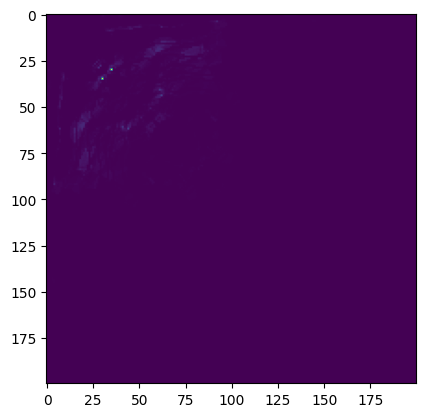

In [24]:
plt.imshow(allprofits)

In [13]:
N = 1095
l = 10
p = 0.35
d = data[-N:]
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])
buy , sell = CUTS(smas[30 , :] , smas[35 , :])
profits = PROFITS(buy , sell,lows[-N:] , highs[-N:], data[-N:] , l , p)
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)

In [14]:
allprofit

563.2717376849072

(50.0, 300.0)

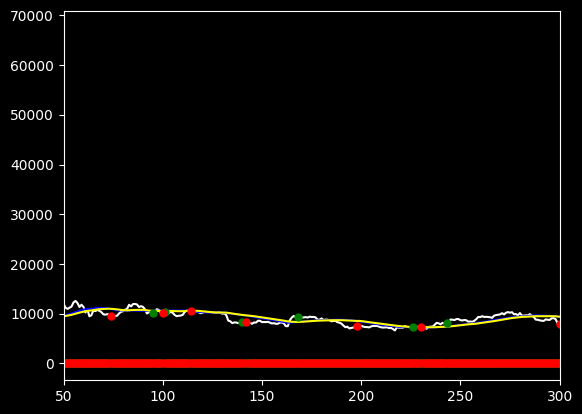

In [17]:
d = data[-N:]
t = np.linspace(0 , N , num = N)
buys = np.zeros(N)
sells = np.zeros(N)
for i in range(N):
    if i in buy:
        buys[i] = d[i]
    if i in sell:
        sells[i] = d[i]
plt.style.use('dark_background')
plt.plot(data[-N:] , color = 'white')
plt.plot(smas[30 , :] , color = 'blue')
plt.plot(smas[35 , :] , color = 'yellow')
plt.plot(t , buys , 'o' , color = 'green' , markersize = 5)
plt.plot(t , sells , 'o' , color = 'red' , markersize = 5)
plt.xlim(50 , 300)
#plt.ylim(18000 , 32000)

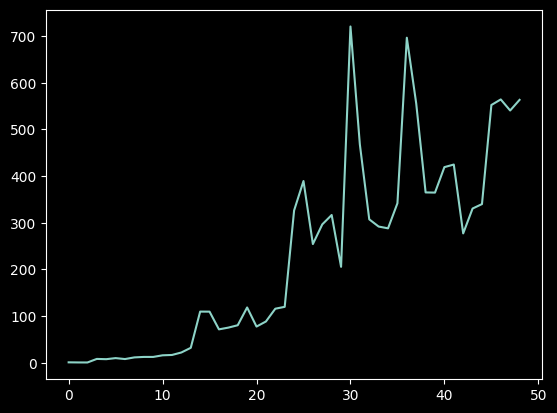

In [16]:
plt.plot(multiplyer)

In [17]:
print(buy[0])
print(d[buy[0]])

37
10912.8232421875


In [18]:
print(sell[1])
print(d[sell[0]])

78
9905.1669921875


In [182]:
profits

[-0.07331499132675766,
 -0.09308203176565313,
 0.13902417915311263,
 0.9267416631496782,
 -0.0557696864922037,
 -0.34320645455593585,
 -0.3504202731274478,
 0.10716299889719184,
 0.001403144777095849,
 -0.34693335967387956,
 -0.09209926686481416,
 0.5451505513594733,
 1.5773730544059998,
 0.17779754270618234,
 -0.02583572075491248,
 -0.08578796052028985,
 -0.18290456161402677,
 -0.3429319854708813,
 -0.23060496462995286,
 -0.09704948882581699,
 11.013914158758265,
 -0.06740867557308208,
 0.29677235868772095,
 -0.19980757931577964,
 0.4444344285225844,
 0.08729294425677421,
 0.0,
 0.278042260487026,
 0.04658060561913885,
 0.3182717014426819,
 0.4537221392454259,
 2.4207182359583057,
 0.0,
 -0.34554832889085635,
 0.053111985174092824,
 0.06898229864539364,
 0.47426603997736505,
 -0.34458209861133615,
 0.1411811569696925,
 0.31085662057112157,
 0.03560736789678363,
 1.7248558065459774,
 0.19446551401578635,
 -0.3461016764449104,
 0.16690990994948604,
 0.06890416137442033,
 -0.35,
 2.50752

In [21]:
pp = np.array(profits)
pp[pp<0]

array([-0.35028013, -0.3393838 , -0.35014004, -0.10238972, -0.35084105,
       -0.34485789, -0.35014004, -0.35      , -0.34115328, -0.11536445,
       -0.34568658, -0.07331499, -0.09308203, -0.05576969, -0.34320645,
       -0.35042027, -0.34693336, -0.09209927, -0.02583572, -0.08578796,
       -0.18290456, -0.34293199, -0.23060496, -0.09704949, -0.06740868,
       -0.19980758, -0.34554833, -0.3445821 , -0.34610168, -0.35      ,
       -0.35      , -0.34252069, -0.04919664, -0.01209639, -0.2016075 ,
       -0.34224677, -0.34665591, -0.04109093])

In [86]:
def detail(buy , sell , profit):
    result = np.zeros ((len(profit) , 4) , dtype = float)
    

In [87]:
multiplyer

[1,
 0.7686256403346771,
 0.6933368839269386,
 8.321360116792585,
 7.752667824100576,
 10.043391895040925,
 8.028609426300704,
 11.585203068641182,
 12.583913044761172,
 12.57132913171641,
 16.05062321092442,
 16.781472689693235,
 22.100418014800447,
 32.095739087739155,
 109.68068951399513,
 109.57100882448114,
 71.63722090046612,
 75.36657389893004,
 80.48496787409866,
 118.53759861058742,
 77.613972452886,
 88.48303127791749,
 115.87257879150091,
 119.87849783734526,
 326.32496929118753,
 389.3941382584034,
 254.36955003513944,
 296.5295223766704,
 316.6446787983535,
 205.61322217771087,
 720.4719291529444,
 467.8384471954645,
 307.2865037893358,
 291.876872745958,
 288.05786994192147,
 341.73662029143287,
 696.4003732125697,
 555.4448353493742,
 364.98028741626337,
 364.6153071288471,
 419.1663094224197,
 424.70121314083787,
 277.19855154793004,
 330.4714622115921,
 339.9836263496483,
 552.2501465312058,
 564.191121768311,
 540.4669774146819,
 563.2717376849072]

(0.0, 35000.0)

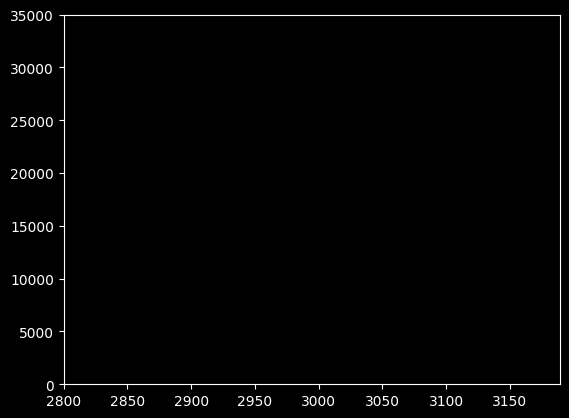

In [88]:
d = data[-N:]
#plt.plot(smas[30 , :])
#plt.plot(smas[35 , :])
t = np.linspace(0 , N , num = N)
buys = np.zeros(N)
sells = np.zeros(N)
for i in range(N):
    if i in buy:
        buys[i] = d[i]
    if i in sell:
        sells[i] = d[i]
plt.style.use('dark_background')
plt.plot(data[-N:] , color = 'white')
plt.plot(t , buys , 'o' , color = 'green' , markersize = 5)
plt.plot(t , sells , 'o' , color = 'red' , markersize = 5)
plt.xlim(2800,3189)
plt.ylim(0 , 35000)

In [36]:
profits

[-0.34665591010805535,
 0.19337659821382427,
 0.029813430855484515,
 0.625969330982337,
 0.022645048069796274,
 -0.04109092730060616,
 0.04323778661791112]

In [93]:
sell

[35,
 82,
 236,
 280,
 301,
 304,
 307,
 318,
 388,
 410,
 462,
 521,
 530,
 631,
 655,
 677,
 803,
 845,
 873,
 882,
 911,
 931,
 990,
 1007,
 1059,
 1074]

In [35]:
d[sell[-1]]

26868.353515625

In [36]:
# Merge the arrays
merged_arr = np.concatenate((buy, sell))

# Sort the merged array
sorted = np.sort(merged_arr)

diff = np.diff(sorted)

avgtradetime = np.mean(diff)
avgtradeprofit = allprofits[30][35] ** (1/3)

In [37]:
check(avgtradetime  , avgtradeprofit)

The best model finished training with avrage trade time of 15.055555555555555 and avrage profit of 1.2238177716301686 per year. :)


In [100]:
N = 2000
l = 10
p = 0.35
d = data[-N:]
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])
buy , sell = CUTS(smas[30 , :] , smas[35 , :])
profits = PROFITS(buy , sell,lows[-N:] , highs[-N:], data[-N:] , l , p)
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)
print(len(buy))

43


In [101]:
allprofit

213.34183697101963

(3190,)

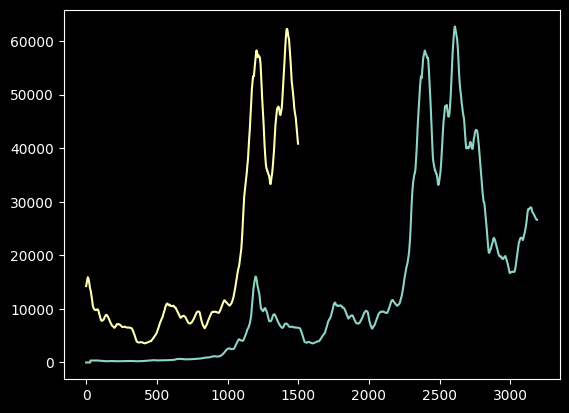

In [207]:
plt.plot(smas[30 , :])
plt.plot(smas[35 , -2000:-500])
smas[30 , :].shape

In [160]:
#threshes
f = 1
thresh = 0.3
N = 3190
m = -1600
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])
l , p = 10 , 0.35
buy , sell = CUTS(smas[30 , m:-500] , smas[35 , m:-500])
profits = PROFITS(buy , sell,lows[m:-500] , highs[ m:-500], data[ m:-500] , l , p)
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)
xtrain , ytrain = SVMDATA(buy , sell , profits , data[m:-500] , smas[30 , m:-500] , smas[35 , -m:-500] , thresh , f)


buy , sell = CUTS(smas[30 , -500:] , smas[35 , -500:])
profits = PROFITS(buy , sell,lows[-500:] , highs[ -500:], data[-500:] , l , p)
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)
xtest , ytest = SVMDATA(buy , sell , profits , data[-500:] , smas[30 , -500:] , smas[35 , -500:] , thresh , f)

allprofit

23
23
13
13


1.7261067668477617

In [364]:
N = 3190
fs = [1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20]
threshs = [-0.3 , -0.2 , -0.1 , 0 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1 , 1.5 , 2]
ts = [1.1  , 1.2 , 1.3 , 1.4 , 1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2 , 2.1 , 2.2 , 2.3 ,2.4 , 2.5]
ms = [-1000 , -1100 , -1200 , -1300 , -1400 , -1500 , -1600 ]
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])
l , p = 10 , 0.35
results = np.zeros ((len(fs) , len(threshs),  len(ms) , len(ts)) , dtype = float)
for i in range(len(fs)):
    print(i)
    for j in range (len(threshs)):
        for k in range(len(ms)):
            for s in range(len(ts)):
                
                f = fs[i]
                thresh = threshs[j]
                m = ms[k]
                t = ts[s]

                buy , sell = CUTS(smas[30 , m:-500] , smas[35 , m:-500])
                profits = PROFITS(buy , sell,lows[m:-500] , highs[ m:-500], data[ m:-500] , l , p)
                numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)
                xtrain , ytrain = SVMDATA(buy , sell , profits , data[m:-500] , smas[30 , m:-500] , smas[35 , -m:-500] , thresh , f)


                buy , sell = CUTS(smas[30 , -500:] , smas[35 , -500:])
                profits = PROFITS(buy , sell,lows[-500:] , highs[ -500:], data[-500:] , l , p)
                numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)
                xtest , ytest = SVMDATA(buy , sell , profits , data[-500:] , smas[30 , -500:] , smas[35 , -500:] , thresh , f)
               
                class_weights = {
                    -1: tp,  # Class 0
                    1: tf*t,  # Class 1
                }
                clf = DecisionTreeClassifier(class_weight=class_weights)            
                
                clf.fit(xtrain, ytrain)
               
                ypred = clf.predict(xtest)
                
                results[i][j][k][s] = accuracy_score(ytest, ypred)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [365]:
np.max(results[: , : , : , :])

1.0

In [366]:
max1 , max2 , max3 , max4 = np.unravel_index(np.argmax(results), results.shape)
print(fs[max1])
print(threshs[max2])
print(ms[max3])
print(ts[max4])

9
1.5
-1300
2.1


In [375]:
f = 9
thresh = 1.5
m = -1300
t = 2.1
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])
buy , sell = CUTS(smas[30 , m:-500] , smas[35 , m:-500])
profits = PROFITS(buy , sell,lows[m:-500] , highs[ m:-500], data[ m:-500] , l , p)
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)
xtrain , ytrain = SVMDATA(buy , sell , profits , data[m:-500] , smas[30 , m:-500] , smas[35 , -m:-500] , thresh , f)
tp = np.mean(ytrain == 1)
tf = 1 - tp

buy , sell = CUTS(smas[30 , -500:] , smas[35 , -500:])
profits = PROFITS(buy , sell,lows[-500:] , highs[ -500:], data[-500:] , l , p)
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits)
xtest , ytest = SVMDATA(buy , sell , profits , data[-500:] , smas[30 , -500:] , smas[35 , -500:] , thresh , f)

class_weights = {
    -1: tp,  # Class 0
    1: tf*t,  # Class 1
}

# Create a decision tree classifier with class weights
#clf = svm.SVC(class_weight=class_weights)
clf = DecisionTreeClassifier(class_weight=class_weights)

clf.fit(xtrain, ytrain)
               
ypred = clf.predict(xtest)

In [376]:
profits

[0.19446551401578635,
 -0.3461016764449104,
 0.16690990994948604,
 0.06890416137442033,
 -0.35,
 2.5075230796777,
 -0.35,
 -0.34252069334799856,
 -0.04919663511142704,
 -0.012096390353447055,
 0.18753464038109266,
 1.039867632824274,
 -0.2016074982546774,
 -0.3422467726799356,
 0.0,
 0.15076324859138437,
 0.014218771699736506,
 -0.34665591010805535,
 0.19337659821382427,
 0.029813430855484515,
 0.625969330982337,
 0.022645048069796274,
 -0.04109092730060616,
 0.04323778661791112]

In [377]:
ytest

array([-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [378]:
ypred

array([-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.])

In [245]:
np.max(results)

0.9166666666666666

In [ ]:
clf = svm.SVC(kernel='linear')  # You can choose different kernel types like 'linear', 'rbf', 'poly', etc.
clf.fit(xtrain, ytrain)

In [214]:
ytest

array([-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.])

In [320]:
ypred = clf.predict(xtest)
n = ypred.shape[0]-1
ypred

array([ 1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])

In [218]:
np.matmul(ytest , ypred)/ypred.shape[0]

0.75

In [321]:
sprof = np.zeros ((n))
pp = profits[:]
for i in range(n):
    if (ypred[i] == -1):
        sprof [i] = 0
    else:
        sprof [i] = pp[i]

In [322]:
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(sprof)
allprofit

1.0489715229951193

In [182]:
#training
clf = svm.SVC(kernel='rbf')  # You can choose different kernel types like 'linear', 'rbf', 'poly', etc.
for i in range (10000):
    X , y = SVMDATA(buy , sell , profits , data[-N:] , smas[30 , :] , smas[35 , :] , 0.1)
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.01, random_state=i)
    clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [22]:
ynew = y[-60:]
ynewpred = clf.predict(X[-60: , :])

In [23]:
ynew

array([-1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,
        1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        1., -1., -1.,  1., -1.,  1., -1., -1., -1.])

In [24]:
ynewpred

array([-1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,
       -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
       -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.])

In [35]:
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits [-10:])
allprofit

1.543293589010988

In [31]:
profits[-60:]

[-0.23060496462995286,
 -0.09704948882581699,
 11.013914158758265,
 -0.06740867557308208,
 0.29677235868772095,
 -0.19980757931577964,
 0.4444344285225844,
 0.08729294425677421,
 0.0,
 0.278042260487026,
 0.04658060561913885,
 0.3182717014426819,
 0.4537221392454259,
 2.4207182359583057,
 0.0,
 -0.34554832889085635,
 0.053111985174092824,
 0.06898229864539364,
 0.47426603997736505,
 -0.34458209861133615,
 0.1411811569696925,
 0.31085662057112157,
 0.03560736789678363,
 1.7248558065459774,
 0.19446551401578635,
 -0.3461016764449104,
 0.16690990994948604,
 0.06890416137442033,
 -0.35,
 2.5075230796777,
 -0.35,
 -0.34252069334799856,
 -0.04919663511142704,
 -0.012096390353447055,
 0.18753464038109266,
 1.039867632824274,
 -0.2016074982546774,
 -0.3422467726799356,
 0.0,
 0.15076324859138437,
 0.014218771699736506,
 -0.34665591010805535,
 0.19337659821382427,
 0.029813430855484515,
 0.625969330982337,
 0.022645048069796274,
 -0.04109092730060616,
 0.04323778661791112]

In [36]:
sprof = np.zeros ((48))
pp = profits[-48:]
for i in range(48):
    if (ynewpred[i] == -1):
        sprof [i] = 0
    else:
        sprof [i] = pp[i]

In [33]:
sprof

array([ 0.        ,  0.        , 11.01391416,  0.        ,  0.29677236,
       -0.19980758,  0.44443443,  0.        ,  0.        ,  0.27804226,
        0.        ,  0.3182717 ,  0.        ,  2.42071824,  0.        ,
       -0.34554833,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.31085662,  0.        ,  1.72485581,  0.19446551,
        0.        ,  0.        ,  0.        ,  0.        ,  2.50752308,
        0.        ,  0.        , -0.04919664, -0.01209639,  0.18753464,
        1.03986763,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01421877, -0.34665591,  0.        ,  0.02981343,  0.62596933,
        0.        ,  0.        ,  0.04323779])

In [37]:
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(sprof[-10:])
allprofit

1.1459949500898776

In [ ]:
xtrain = data[-2000:]

In [676]:
profits[-30:]

array([ 0.47426604, -0.3445821 ,  0.14118116,  0.31085662,  0.03560737,
        1.72485581,  0.19446551, -0.34610168,  0.16690991,  0.06890416,
       -0.35      ,  2.50752308, -0.35      , -0.34252069, -0.04919664,
       -0.01209639,  0.18753464,  1.03986763, -0.2016075 , -0.34224677,
        0.        ,  0.15076325,  0.01421877, -0.34665591,  0.1933766 ,
        0.02981343,  0.62596933,  0.02264505, -0.04109093,  0.04323779])

In [554]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [110]:
X , y = SVMDATA(buy , sell , profits , data[-N:] , smas[30 , :] , smas[35 , :] , 0.7)
from imblearn.over_sampling import SMOTE



In [111]:
acc = []
for i in range (1000):
    # Instantiate the SMOTE resampler
    smote = SMOTE()
    # Resample the data
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=i)
    clf = svm.SVC(kernel='rbf')  # You can choose different kernel types like 'linear', 'rbf', 'poly', etc.
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)
print("Accuracy:", np.mean(np.array(acc)))

Accuracy: 0.7201333333333333


In [112]:
profits = np.array(profits)
numtrades , maxdrawdown , maxwin , allprofit , multiplyer = RATE(profits[profits > 1])

In [114]:
profits

array([-3.50280126e-01, -3.39383798e-01, -3.50140035e-01, -1.02389719e-01,
       -3.50841051e-01, -3.44857888e-01,  1.95268414e-01,  4.82291905e-02,
        1.16052208e-01,  6.34439837e-02, -3.50140035e-01,  1.32025483e+00,
       -3.50000000e-01, -3.41153279e-01,  1.27428919e-01, -1.15364447e-01,
        4.37185550e+00, -3.45686583e-01, -7.33149913e-02, -9.30820318e-02,
        1.39024179e-01,  9.26741663e-01, -5.57696865e-02, -3.43206455e-01,
       -3.50420273e-01,  1.07162999e-01,  1.40314478e-03, -3.46933360e-01,
       -9.20992669e-02,  5.45150551e-01,  1.57737305e+00,  1.77797543e-01,
       -2.58357208e-02, -8.57879605e-02, -1.82904562e-01, -3.42931985e-01,
       -2.30604965e-01, -9.70494888e-02,  1.10139142e+01, -6.74086756e-02,
        2.96772359e-01, -1.99807579e-01,  4.44434429e-01,  8.72929443e-02,
        0.00000000e+00,  2.78042260e-01,  4.65806056e-02,  3.18271701e-01,
        4.53722139e-01,  2.42071824e+00,  0.00000000e+00, -3.45548329e-01,
        5.31119852e-02,  

In [723]:
N = 1500
thresh = 0.2
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])

buy , sell = CUTS(smas[30 , :] , smas[35 , :])
profits = PROFITS(buy , sell,lows[-N:] , highs[-N:], data[-N:] , l , p)

x , y = SVMDATA(buy , sell , profits , data[-N:] , smas[30 , :] , smas[35 , :] , thresh , 20)

xr = np.zeros((int(np.sum(y[y==1])) , 3) , dtype = float)
xw = np.zeros((int(-1*np.sum(y[y==-1])) , 3) , dtype = float)

r = 0 
w = 0

for i in range(y.shape[0]):
    if (y[i]==1):
        xr[r , :] = x[i , :]
        r = r+1
for i in range(y.shape[0]):
    if (y[i]==-1):
        xw[w , :] = x[i , :]
        w = w+1       

        

ValueError: could not broadcast input array from shape (60,) into shape (3,)

Text(0.5, 0.92, '3D Plot')

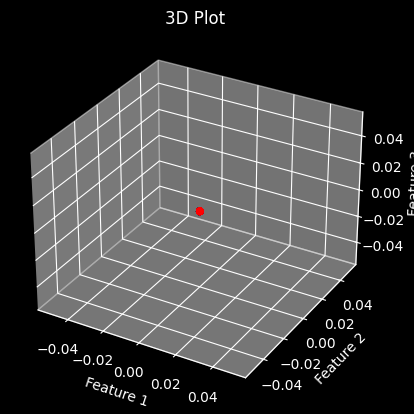

In [724]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(xr[: , 0], xr[: , 1], xr[: , 2], c='blue', marker='o')
ax.scatter(xw[: , 0], xw[: , 0], xw[: , 2], c='red', marker='o')

#ax.set_xlim([0.6, 1.1])
#ax.set_ylim([0.6, 1.1])
#ax.set_zlim([0.6, 1.1])

# Customize the plot
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Plot')

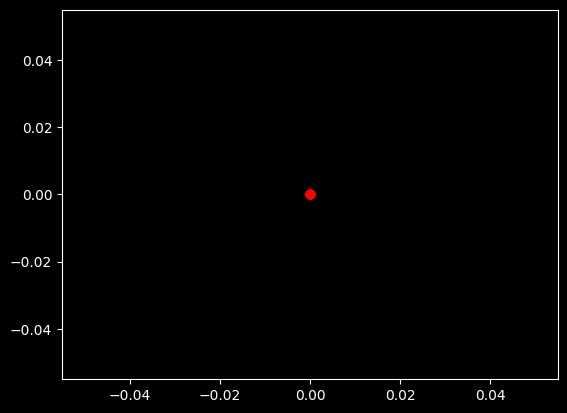

In [725]:
plt.figure()
plt.scatter(xr[: , 0], xr[: , 1] , color = 'blue' )
plt.scatter(xw[: , 0], xw[: , 1] , color = 'red')

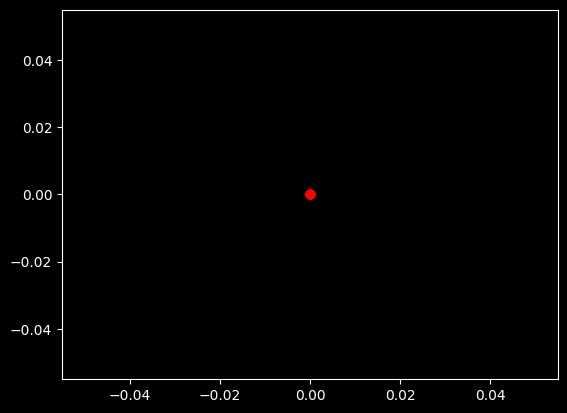

In [726]:
plt.figure()
plt.scatter(xr[: , 2], xr[: , 1] , color = 'blue' )
plt.scatter(xw[: , 2], xw[: , 1] , color = 'red')

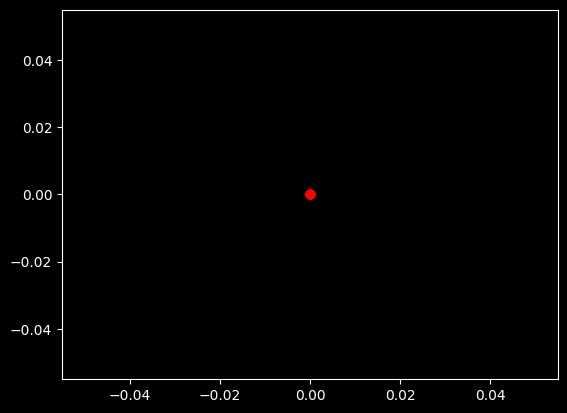

In [727]:
plt.figure()
plt.scatter(xr[: , 0], xr[: , 2] , color = 'blue' )
plt.scatter(xw[: , 0], xw[: , 2] , color = 'red')

In [335]:
def SVMDATA(buys , sells , profits , data , sma1 , sma2 , thresh , f):
    feature = np.zeros ((len(profits)+1 , 3*f))
    result = np.zeros (len(profits))
    for i in range(len(profits)):
        if (profits[i]>thresh):
            result[i] = 1
        else :
            result [i] = -1
    long = -1
    if (buys[0] > sells[0]):
        sells = sells[1:]
    else :
        long = 1
        buys = buys[1:]
    entrys = []
    for i in range(min(len(buys) , len(sells))):
        if (long == 1):
            entrys.append(sells[i])
            entrys.append(buys[i])
        else :
            entrys.append(buys[i])
            entrys.append(sells[i])
    if (len(buys) == len(sells)):
        entrys = entrys [:-1]
    for i in range(len(entrys)):
        d1 = []
        for j in range (f):
            d1.append(sma1[entrys[i]-j])
            d1.append(sma2[entrys[i]-j])
            d1.append(data[entrys[i]-j])
        d1 = np.array(d1)
        if (i == len(entrys)-1):
            print(d1)
        d1 = d1/np.max(d1)
        feature [i , :] = d1
        
    return feature , result

In [341]:
data = df['Close'].values
lows = df['Low'].values
highs = df['High'].values
data = data[:-1]
lows = lows[:-1]
highs = highs[:-1]

In [342]:
N = 3000
thresh = 0
f = 15
l = 10 
p = 0.35
smas = np.zeros((200 , N) , dtype = float)
for i in range (200):
    smas [i , :] = SMA(i+1 , data[-N:])

buy , sell = CUTS(smas[30 , :] , smas[35 , :])
profits = PROFITS(buy , sell , lows[-N:] , highs[-N:], data[-N:] , l , p)


x , y = SVMDATA(buy , sell , profits , data[-N:] , smas[30 , :] , smas[35 , :] , thresh , f)

xr = np.zeros((int(np.sum(y[y==1])) , 3*f) , dtype = float)
xw = np.zeros((int(-1*np.sum(y[y==-1])) , 3*f) , dtype = float)

pca = PCA(n_components=2)
xpca = pca.fit_transform(x)

xpca = xpca[(xpca < 1).all(axis=1)]
xr = np.zeros((int(np.sum(y[y==1])) , 2) , dtype = float)
xw = np.zeros((int(-1*np.sum(y[y==-1])) , 2) , dtype = float)

r = 0 
w = 0

for i in range(xpca.shape[0]-1):
    if (y[i]==1):
        xr[r , :] = xpca[i , :]
        r = r+1
for i in range(xpca.shape[0]-1):
    if (y[i]==-1):
        xw[w , :] = xpca[i , :]
        w = w+1 
        
plt.figure(figsize = (20, 20))
plt.scatter(xr[: , 0], xr[: , 1] , color = 'blue' )
plt.scatter(xw[: , 0], xw[: , 1] , color = 'red')
plt.scatter(xpca[-1 , 0] , xpca[-1 , 1] , color = 'green')
for i in range(xpca.shape[0]-1):
    plt.text(xpca[i, 0], xpca[i, 1], np.round(profits[i] , 2), ha='center', va='center' , fontsize = '8')
#plt.xlim(-0.4 , -0.3)
#plt.ylim(-0.1 , -0.05)

short
62
62
entry
26868.353515625
[27812.8703377  27796.00287543 26476.20703125 27846.71333165
 27861.18267144 26334.81835938 27887.24773185 27974.03640408
 27225.7265625  27906.33719758 28035.68413628 26851.27734375
 27920.06728831 28131.90852865 26753.82617188 27968.2015499
 28230.92713759 27129.5859375  28022.81747732 28324.15250651
 26890.12890625 28135.96018145 28421.62299262 26832.20898438
 28220.24521169 28513.47976345 27398.80273438 28314.32755796
 28592.26464844 27036.65039062 28420.19354839 28664.94048394
 27192.69335938 28526.41954385 28696.61707899 26930.63867188
 28638.30430948 28724.87141927 26784.078125   28746.52929688
 28756.5875651  26804.99023438 28857.17666331 28791.00840929
 27000.7890625 ]
0.9638112093296801
(123, 2)


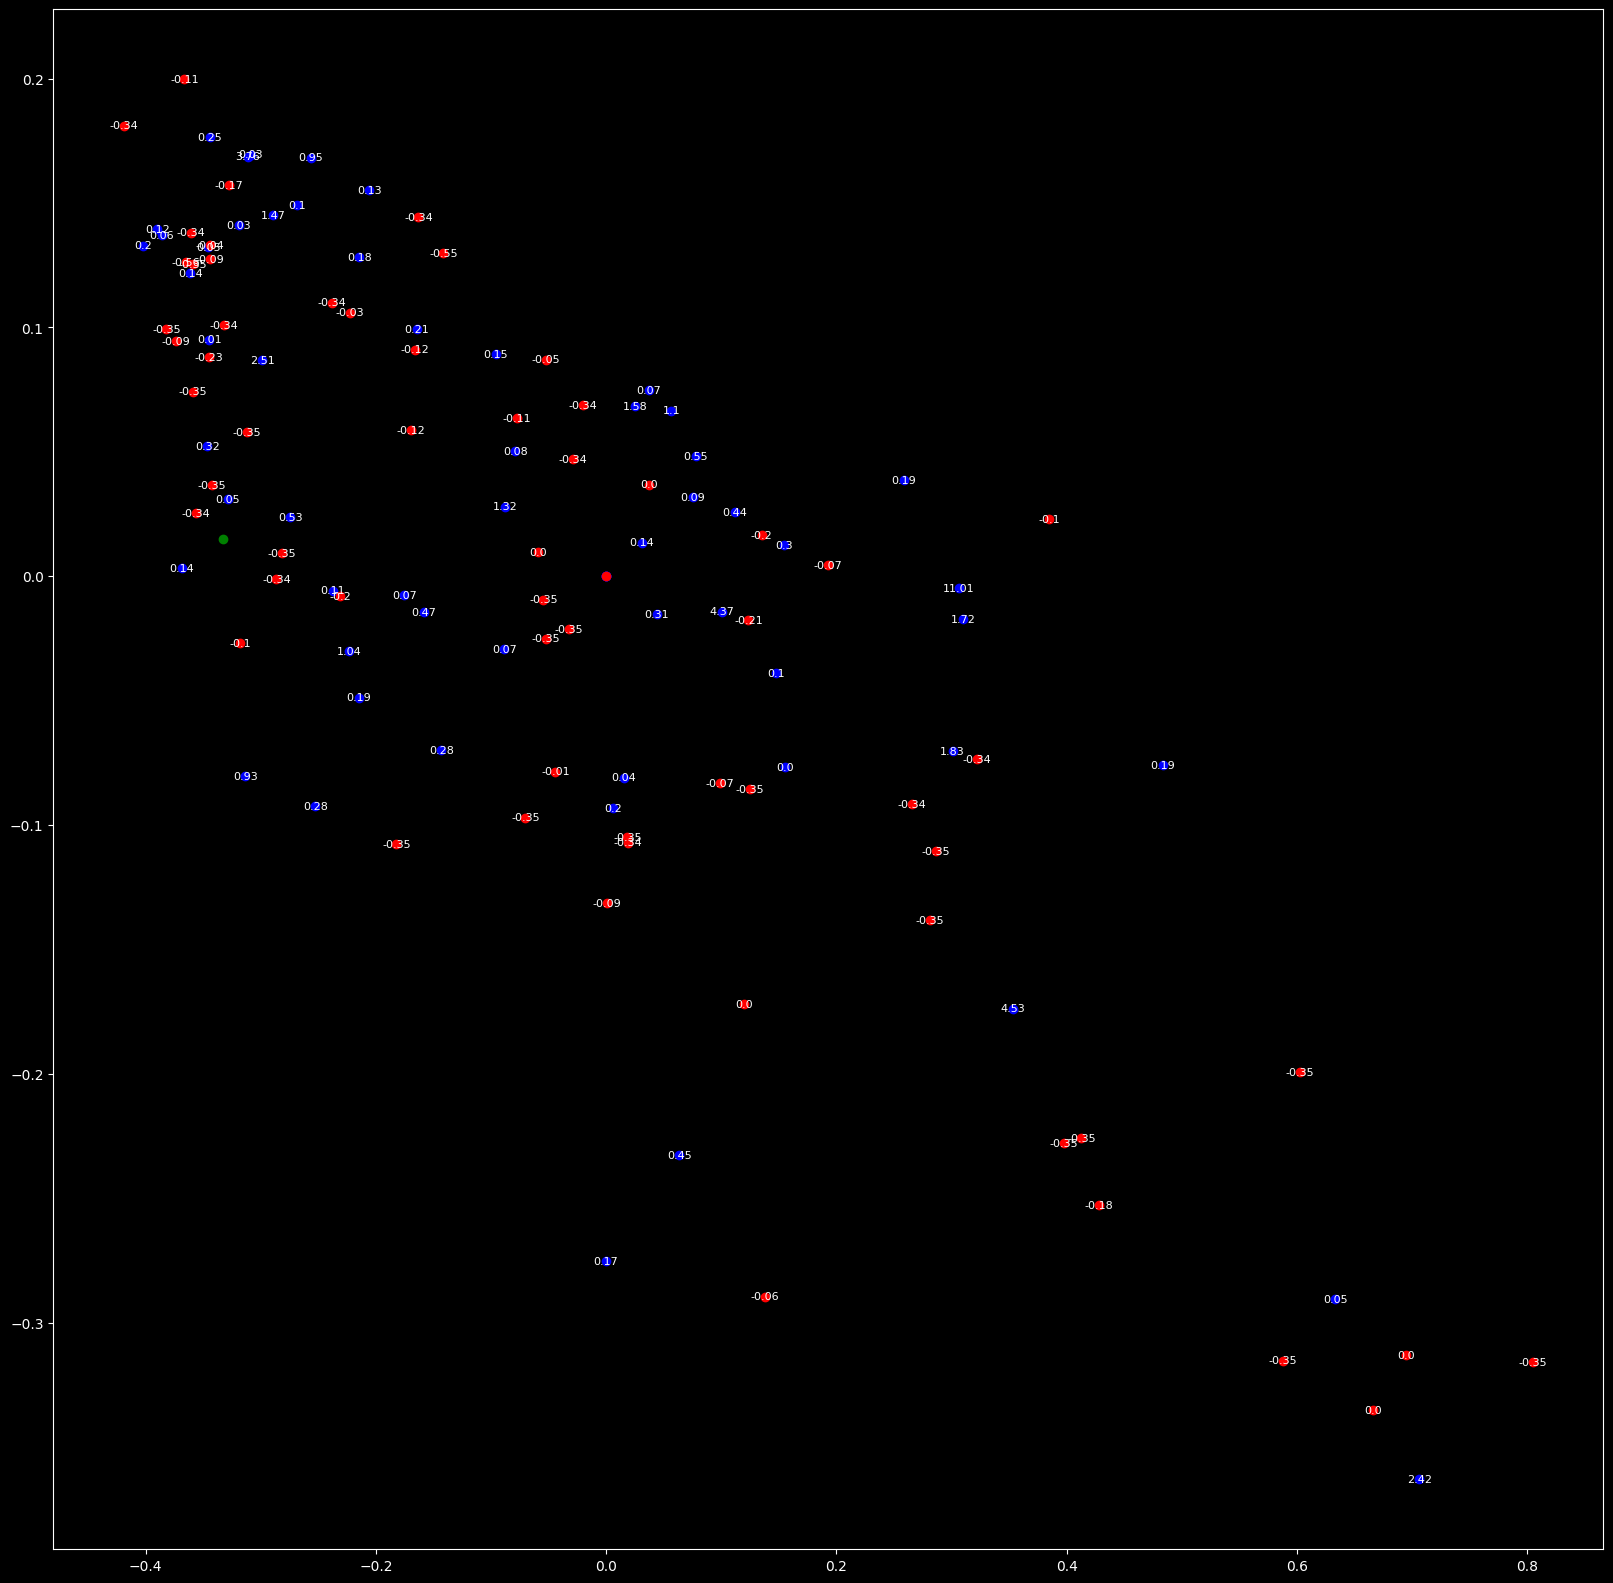

In [347]:
plt.figure(figsize = (20, 20))
plt.scatter(xr[: , 0], xr[: , 1] , color = 'blue' )
plt.scatter(xw[: , 0], xw[: , 1] , color = 'red')
plt.scatter(xpca[-1 , 0] , xpca[-1 , 1] , color = 'green')
for i in range(xpca.shape[0]-1):
    plt.text(xpca[i, 0], xpca[i, 1], np.round(profits[i] , 2), ha='center', va='center' , fontsize = '8')
#plt.xlim(-0.4 , -0.3)
#plt.ylim(-0.1 , -0.05)

In [186]:
def PCAresults(xpca , profits , n):
    point = xpca [-1 , :]
    distances = np.zeros ((len(profits)-1))
    for i in range (len(profits)-1):
        distances[i] = (np.linalg.norm(point - xpca[i , :]))
    indx = np.argsort(distances)[:n]
    s = 0
    for i in range (n):
        s = s + profits[indx[i]]
        print(profits[indx[i]])
    return s


In [188]:
PCAresults (xpca , profits , 3)

0.9267416631496782
0.0
-0.34554832889085635


0.5811933342588218

In [37]:
profits

[-0.07331499132675766,
 -0.09308203176565313,
 0.13902417915311263,
 0.9267416631496782,
 -0.0557696864922037,
 -0.34320645455593585,
 -0.3504202731274478,
 0.10716299889719184,
 0.001403144777095849,
 -0.34693335967387956,
 -0.09209926686481416,
 0.5451505513594733,
 1.5773730544059998,
 0.17779754270618234,
 -0.02583572075491248,
 -0.08578796052028985,
 -0.18290456161402677,
 -0.3429319854708813,
 -0.23060496462995286,
 -0.09704948882581699,
 11.013914158758265,
 -0.06740867557308208,
 0.29677235868772095,
 -0.19980757931577964,
 0.4444344285225844,
 0.08729294425677421,
 0.0,
 0.278042260487026,
 0.04658060561913885,
 0.3182717014426819,
 0.4537221392454259,
 2.4207182359583057,
 0.0,
 -0.34554832889085635,
 0.053111985174092824,
 0.06898229864539364,
 0.47426603997736505,
 -0.34458209861133615,
 0.1411811569696925,
 0.31085662057112157,
 0.03560736789678363,
 1.7248558065459774,
 0.19446551401578635,
 -0.3461016764449104,
 0.16690990994948604,
 0.06890416137442033,
 -0.35,
 2.50752

In [228]:
buy

[39,
 110,
 239,
 281,
 301,
 303,
 307,
 385,
 402,
 409,
 480,
 526,
 613,
 643,
 655,
 761,
 840,
 855,
 873,
 908,
 910,
 941,
 996,
 1010,
 1070]

In [229]:
sell

[35,
 80,
 234,
 278,
 299,
 302,
 305,
 316,
 386,
 408,
 460,
 519,
 528,
 629,
 653,
 675,
 801,
 843,
 871,
 880,
 909,
 929,
 988,
 1005,
 1057,
 1072]

In [230]:
test

(array([[0.86085222, 0.85943888, 1.        ],
        [0.99952883, 1.        , 0.90307079],
        [0.99685487, 0.99540726, 1.        ],
        [0.77252538, 0.77524183, 1.        ],
        [0.79083145, 0.79033277, 1.        ],
        [0.99607762, 1.        , 0.98877634],
        [0.95561367, 0.9550833 , 1.        ],
        [0.91557731, 0.91680187, 1.        ],
        [0.94480919, 0.94468148, 1.        ],
        [0.95961359, 0.96005454, 1.        ],
        [1.        , 0.99897068, 0.9662454 ],
        [0.99999295, 1.        , 0.97306113],
        [1.        , 0.99876131, 0.89507468],
        [0.98960214, 0.99026367, 1.        ],
        [1.        , 0.99931855, 0.95904485],
        [0.99983942, 1.        , 0.95435912],
        [0.89566536, 0.89343043, 1.        ],
        [0.86683193, 0.86704535, 1.        ],
        [0.88828859, 0.88736666, 1.        ],
        [0.9988438 , 1.        , 0.91780861],
        [0.85037834, 0.84596629, 1.        ],
        [0.99812213, 1.        , 0